# Imports

In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys-dmm/')
from projects.ephys.population import Population
import pandas as pd
from src.utils.path import find
from src.utils.auxiliary import flatten_series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import xarray as xr
from matplotlib.patches import Ellipse

In [2]:
mpl.rcParams.update({'font.size': 25})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [3]:
%matplotlib inline

# Load datasets

In [4]:
hffm_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_gratfix')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_gratfix.pickle


In [7]:
opfl = Population(savepath=hffm_savepath)
opfl.load(fname='hffm_optic_flow')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_optic_flow.pickle


In [30]:
ltdk_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/ltdk'
ltdk = Population(savepath=ltdk_savepath)
ltdk.load(fname='ltdk_pop')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/ltdk/ltdk_pop.pickle


# Reorganize some data, set up example data

In [8]:
# merge optic flow columns into the main hffm object
opfl_cols = ['has_optic_flow','has_topdown_optic_flow','FmLt_flowvec_scale']
movement_state_list = ['full','active_gyro','inactive_gyro','running_forward','running_backward','fine_motion','immobile']
for movement_state in movement_state_list:
    opfl_cols.append('FmLt_optic_flow_'+movement_state+'_amp')
    opfl_cols.append('FmLt_optic_flow_'+movement_state+'_vec')
for col in opfl_cols:
    hffm.data[col] = opfl.data[col]

In [6]:
demo = hffm.data[hffm.data['session']=='102621_J558NC_control_Rig2'].iloc[0]

In [29]:
hffm.data['session'].unique()

array(['062921_G6HCK1ALTRN_control_Rig2', '070921_J553RT_control_Rig2',
       '101521_J559NC_control_Rig2', '102621_J558NC_control_Rig2',
       '110321_J558LT_control_Rig2', '110421_J569LT_control_Rig2',
       '122021_J581RT_control_Rig2', '020222_J577TT_control_Rig2',
       '020422_J577RT_control_Rig2'], dtype=object)

In [31]:
for rsession in ['020222_J577TT_control_Rig2','020422_J577RT_control_Rig2']:
    dropinds = hffm.data[hffm.data['session']==rsession].index.values
    hffm.data.drop(index=dropinds, inplace=True)

In [32]:
ltdk.data['session'].unique()

array(['100821_J559TT_control_Rig2', '101621_J559NC_control_Rig2',
       '102721_J558NC_control_Rig2', '110421_J558LT_control_Rig2',
       '110521_J569LT_control_Rig2', '020322_J577TT_control_Rig2',
       '020522_J577RT_control_Rig2'], dtype=object)

In [33]:
for rsession in ['020322_J577TT_control_Rig2','020522_J577RT_control_Rig2']:
    dropinds = ltdk.data[ltdk.data['session']==rsession].index.values
    ltdk.data.drop(index=dropinds, inplace=True)

# Figure 01: pupil data

In [ ]:
def drop_wraparound(vals, thresh=70, win=2):
    drop = [i for i in range(len(vals)-1) if np.abs(np.diff(vals))[i]>thresh]
    if len(drop) > 0:
        for i in drop:
            vals[i-win:i+win] = np.nan
    return vals

In [ ]:
def plot_raster(panel, data, start=0, win=15, stim='FmLt'):
    n_cells = len(data.index.values)
    for i, ind in enumerate(data.index.values):
        panel.vlines(data.loc[ind, stim+'_spikeT'][data[stim+'_spikeT']>start][data[stim+'_spikeT']<start+win], i-0.25, i+0.25, 'k', linewidth=0.25)
    panel.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
    panel.set_xlim([start, start+win]); panel.set_ylim([n_cells+0.25, -.25])

In [ ]:
hffm.data['session'].unique()

In [ ]:
FmLt_demo_dir = '/home/niell_lab/Documents/ex_data/102621_J558NC/FmLt'

In [ ]:
FmLt_eye_demo = xr.open_dataset(os.path.join(FmLt_demo_dir, '102621_J558NC_control_Rig2_fm1_REYE.nc'))

In [ ]:
FmLt_eye_demo

In [ ]:
pts = FmLt_eye_demo.REYE_pts
ell = FmLt_eye_demo.REYE_ellipse_params

In [ ]:
eye_frames = FmLt_ephys_demo['FmLt_eyeT'][1700:1750]

In [ ]:
ell_frames = .sel()

In [ ]:
cmap = plt.cm.summer(np.linspace(0,1,50))

start = 1720
for f in range(start,start+50):
    for i in range(1,9):
        plt.plot(pts.sel(frame=f).sel(point_loc='pt'+str(i)+'_x').values,
                 pts.sel(frame=f).sel(point_loc='pt'+str(i)+'_y').values,
                '.', color=cmap[f-start], markersize=15)
        
        mean_spot_x = pts.sel(frame=f).sel(point_loc=['spot1_x','spot2_x','spot3_x','spot4_x','spot_cent_x']).mean().values
        mean_spot_y = pts.sel(frame=f).sel(point_loc=['spot1_y','spot2_y','spot3_y','spot4_y','spot_cent_y']).mean().values
        
        ellipse_phi = np.rad2deg(ell.sel(frame=f).sel(ellipse_params='ellipse_phi').values)
        x = ((ell.sel(frame=f).sel(ellipse_params='X0').values)+mean_spot_x)
        y = ((ell.sel(frame=f).sel(ellipse_params='Y0').values)+mean_spot_y)
        long_axis = (ell.sel(frame=f).sel(ellipse_params='longaxis').values)
        short_axis = (ell.sel(frame=f).sel(ellipse_params='shortaxis').values)

        ell = Ellipse((x, y), long_axis, short_axis, ellipse_phi, edgecolor=cmap[f-start], facecolor='none')
        ax.add_patch(ell)
        
cb = plt.cm.ScalarMappable(norm=None, cmap='summer')
cb.set_array(np.linspace(0,1,50))
cb.set_clim((0., 50.))
plt.colorbar(cb)
plt.axis('off')



In [ ]:
cb

In [ ]:
pupil_pts = 

In [ ]:
FmLt_eye_demo.timestamps.values[1700:1750] - FmLt_ephys_demo['t0']

In [ ]:
savename = '01_pupil_data' # demonstrate the steps of preprocessing

start = 1700 # frames, not seconds
end = start+(15*60)

fig = plt.figure(constrained_layout=True, figsize=(10,8))
spec = gridspec.GridSpec(nrows=5, ncols=2, figure=fig)

ax_frame = fig.add_subplot(spec[0:3,0])

ax_XY = fig.add_subplot(spec[3,0])
ax_radius = fig.add_subplot(spec[4,0])
ax_theta = fig.add_subplot(spec[2,1])
ax_phi = fig.add_subplot(spec[3,1])
ax_dEye = fig.add_subplot(spec[4,1])

ax_theta.plot(demo['FmLt_theta'][start:end], color='k', linewidth=1)
ax_theta.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
ax_theta.set_xlim([0,15*60]); ax_theta.set_ylim([-50,50])
ax_theta.set_ylabel('theta (deg)')

ax_phi.plot(-demo['FmLt_phi'][start:end], color='k', linewidth=1)
ax_phi.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
ax_phi.set_xlim([0,15*60]); ax_phi.set_ylim([-70,70])
ax_phi.set_ylabel('phi (deg)')

ax_dEye.plot(demo['FmLt_dEye_dps'][start:end], color='k', linewidth=1)
ax_dEye.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
ax_dEye.set_xlim([0,15*60]); ax_dEye.set_ylim([-600,600])
ax_dEye.set_ylabel('dEye (deg/sec)')

fig.show()

In [ ]:
savename = '02_topdown_data' # demonstrate the steps of preprocessing

start = 1000
end = start+(15*60)

fig = plt.figure(constrained_layout=True, figsize=(10,8))
spec = gridspec.GridSpec(nrows=5, ncols=2, figure=fig)

ax_frame = fig.add_subplot(spec[0:3,0])

ax_XY = fig.add_subplot(spec[3,0])
ax_speed = fig.add_subplot(spec[4,0])
ax_disp = fig.add_subplot(spec[2,1])
ax_bodyyaw = fig.add_subplot(spec[3,1])
ax_headyaw = fig.add_subplot(spec[4,1])

ax_speed.plot(demo['FmLt_top_speed'][start:end], color='k', linewidth=1)
ax_speed.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
ax_speed.set_xlim([0,15*60]); #ax_speed.set_ylim([-50,50])
ax_speed.set_ylabel('speed (cm/sec)')

ax_disp.plot(drop_wraparound(demo['FmLt_top_movement_yaw'][start:end]), color='k', linewidth=1)
ax_disp.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
ax_disp.set_xlim([0,15*60])
ax_disp.hlines(0, 0, 15*60, colors='tab:orange', linewidth=1, linestyles='dashed') # rightwards horizontal in arena
ax_disp.set_ylabel('direction of motion (deg)')

ax_bodyyaw.plot(drop_wraparound(demo['FmLt_top_body_yaw'][start:end]), color='k', linewidth=1)
ax_bodyyaw.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
ax_bodyyaw.set_xlim([0,15*60])
ax_bodyyaw.hlines(0, 0, 15*60, colors='tab:orange', linewidth=1, linestyles='dashed') # rightwards horizontal in arena
ax_bodyyaw.set_ylabel('body yaw (deg)')

ax_headyaw.plot(drop_wraparound(demo['FmLt_top_head_yaw'][start:end]), color='k', linewidth=1)
ax_headyaw.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
ax_headyaw.set_xlim([0,15*60])
ax_headyaw.hlines(0, 0, 15*60, colors='tab:orange', linewidth=1, linestyles='dashed') # rightwards horizontal in arena
ax_headyaw.set_ylabel('head yaw (deg)')

fig.show()

In [ ]:
savename = '03_imu_data'

In [ ]:
savename = '04_ephys_data' # raster, depth from LFP

In [ ]:
savename = '05_world_data' # Wn and Grat analysis, optic flow

In [ ]:
savename = '06_headfixed_recording' # demonstrate the steps of preprocessing

# start = 1700
# end = start+(15*60)

fig = plt.figure(constrained_layout=True, figsize=(10,8))
spec = gridspec.GridSpec(nrows=6, ncols=4, figure=fig)

ax_Wn_contrast = fig.add_subplot(spec[0,0:2])
ax_Wn_raster = fig.add_subplot(spec[1:3,0:2])

ax_Wn_tuning_u1 = fig.add_subplot(spec[0,2])
ax_Wn_tuning_u2 = fig.add_subplot(spec[1,2])
ax_Wn_tuning_u3 = fig.add_subplot(spec[2,2])

ax_Wn_sta_u1 = fig.add_subplot(spec[0,3])
ax_Wn_sta_u2 = fig.add_subplot(spec[1,3])
ax_Wn_sta_u3 = fig.add_subplot(spec[2,3])

ax_Gt_contrast = fig.add_subplot(spec[3,0:2])
ax_Gt_raster = fig.add_subplot(spec[4:6,0:2])

ax_Gt_psth_u1 = fig.add_subplot(spec[3,2])
ax_Gt_psth_u2 = fig.add_subplot(spec[4,2])
ax_Gt_psth_u3 = fig.add_subplot(spec[5,2])

ax_Gt_tuning_u1 = fig.add_subplot(spec[3,3])
ax_Gt_tuning_u2 = fig.add_subplot(spec[4,3])
ax_Gt_tuning_u3 = fig.add_subplot(spec[5,3])


plot_raster(ax_Wn_raster, data=hffm.data[hffm.data['session']=='102821_J570LT_control_Rig2'], stim='Wn')

plot_raster(ax_Gt_raster, data=hffm.data[hffm.data['session']=='102821_J570LT_control_Rig2'], stim='Gt')

# ax_XY = fig.add_subplot(spec[3,0])
# ax_radius = fig.add_subplot(spec[4,0])
# ax_theta = fig.add_subplot(spec[2,1])
# ax_phi = fig.add_subplot(spec[3,1])
# ax_dEye = fig.add_subplot(spec[4,1])

# ax_theta.plot(demo['FmLt_theta'][start:end], color='k', linewidth=1)
# ax_theta.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
# ax_theta.set_xlim([0,15*60]); ax_theta.set_ylim([-50,50])
# ax_theta.set_ylabel('theta (deg)')

# ax_phi.plot(-demo['FmLt_phi'][start:end], color='k', linewidth=1)
# ax_phi.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
# ax_phi.set_xlim([0,15*60]); ax_phi.set_ylim([-70,70])
# ax_phi.set_ylabel('phi (deg)')

# ax_dEye.plot(demo['FmLt_dEye_dps'][start:end], color='k', linewidth=1)
# ax_dEye.set_xticks(ticks=np.linspace(0,15*60,6), labels=np.arange(0,18,3))
# ax_dEye.set_xlim([0,15*60]); ax_dEye.set_ylim([-600,600])
# ax_dEye.set_ylabel('dEye (deg/sec)')

fig.show()

# Figure 08: Saccade and fixate

In [ ]:
def eyemov_psth(panel, i, movtype):
    right = hffm.data['FmLt_rightsacc_avg_'+movtype+'_dEye'][hffm.data['session']=='102621_J558NC_control_Rig2'][hffm.data['index']==i].iloc[0]
    panel.plot(hffm.trange_x, right, color=hffm.cmap_sacc[0])
    left = hffm.data['FmLt_leftsacc_avg_'+movtype+'_dEye'][hffm.data['session']=='102621_J558NC_control_Rig2'][hffm.data['index']==i].iloc[0]
    panel.plot(hffm.trange_x, left, color=hffm.cmap_sacc[1])
    maxval = np.max(np.maximum(right, left))*1.2
    panel.set_ylim([0, maxval])
    panel.set_xlim([-0.2, 0.4])

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10,8))
spec = gridspec.GridSpec(nrows=6, ncols=8, figure=fig)

start = 2090 #2100
win = 60 # frames, not sec
ex_units = [466,40,266,13]

ax_deyehead = fig.add_subplot(spec[0:3,0:3])
ax_theta = fig.add_subplot(spec[0,3:6])
ax_headyaw = fig.add_subplot(spec[1,3:6])
ax_dEye = fig.add_subplot(spec[2,3:6])
ax_dHead = fig.add_subplot(spec[3,3:6])
ax_gaze = fig.add_subplot(spec[4:,3:6])
ax_u1_gazeshift = fig.add_subplot(spec[2,6])
ax_u1_comp = fig.add_subplot(spec[2,7])
ax_u2_gazeshift = fig.add_subplot(spec[3,6])
ax_u2_comp = fig.add_subplot(spec[3,7])
ax_u3_gazeshift = fig.add_subplot(spec[4,6])
ax_u3_comp = fig.add_subplot(spec[4,7])
ax_u4_gazeshift = fig.add_subplot(spec[5,6])
ax_u4_comp = fig.add_subplot(spec[5,7])

# sthresh = 5/0.016
# right = eyeT[(np.append(dEye, 0) > sthresh) & (np.append(dGaze,0) > sthresh)]
# left = eyeT[(np.append(dEye, 0) < -sthresh) & (np.append(dGaze,0) < -sthresh)]
# compinds = [f for f in np.arange(0,len(dEye)) if f not in right and f not in left]
# ax_deyehead.plot(dEye[right][::10], dHead[right][::10], '.', color=hffm.cmap_sacc[0], markersize=2)
# ax_deyehead.plot(dEye[left][::10], dHead[left][::10], '.', color=hffm.cmap_sacc[1], markersize=2)
# ax_deyehead.plot(dEye[compinds][::10], dHead[compinds][::10], '.', color='gray', markersize=3)
ax_deyehead.plot(demo['FmLt_dHead'][::10], demo['FmLt_dEye_dps'][::10], 'k.', markersize=2)
ax_deyehead.axis('equal')
ax_deyehead.set_xlim([-600,600]); ax_deyehead.set_ylim([-600,600])
ax_deyehead.set_xlabel('dHead (deg/sec)'); ax_deyehead.set_ylabel('dEye (deg/sec)')
ax_deyehead.plot([-500,500],[500,-500], 'r:')

theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
ax_theta.plot(theta_data, 'k-', linewidth=1)
ax_theta.set_xlim([0,60]); ax_theta.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_theta.set_ylabel('theta (deg)')
ax_theta.set_ylim([-10,10])

ax_dEye.plot(demo['FmLt_dEye_dps'][start:start+win], 'k-', linewidth=1)
ax_dEye.set_xlim([0,60]); ax_dEye.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_dEye.set_ylabel('dEye (deg/sec)')
ax_dEye.set_ylim([-500,500])

dHead_data = demo['FmLt_dHead'][start:start+win]
ax_dHead.plot(dHead_data, 'k-', linewidth=1)
ax_dHead.set_xlim([0,60]); ax_dHead.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_dHead.set_ylabel('dHead (deg/sec)')
ax_dHead.set_ylim([-500,500])

pYaw = np.nancumsum(dHead_data*0.016)
pYaw = pYaw - np.nanmean(pYaw)
ax_headyaw.plot(pYaw, 'k-', linewidth=1)
ax_headyaw.set_xlim([0,60]); ax_headyaw.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_headyaw.set_ylabel('head yaw (deg)')
# ax_headyaw.set_ylim([-10,10])

ax_gaze.plot(pYaw + theta_data, 'k-', linewidth=1)
ax_gaze.set_xlim([0,60]); ax_gaze.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_gaze.set_ylabel('gaze (theta + head yaw, deg)')

eyemov_psth(ax_u1_gazeshift, ex_units[0], 'gaze_shift')
eyemov_psth(ax_u2_gazeshift, ex_units[1], 'gaze_shift')
eyemov_psth(ax_u3_gazeshift, ex_units[2], 'gaze_shift')
eyemov_psth(ax_u4_gazeshift, ex_units[3], 'gaze_shift')

eyemov_psth(ax_u1_comp, ex_units[0], 'comp')
eyemov_psth(ax_u2_comp, ex_units[1], 'comp')
eyemov_psth(ax_u3_comp, ex_units[2], 'comp')
eyemov_psth(ax_u4_comp, ex_units[3], 'comp')

ax_u1_gazeshift.set_ylim([0,16]); ax_u1_comp.set_ylim([0,16])
ax_u2_gazeshift.set_ylim([0,9]); ax_u2_comp.set_ylim([0,9])
ax_u3_gazeshift.set_ylim([0,58]); ax_u3_comp.set_ylim([0,58])
ax_u4_gazeshift.set_ylim([0,17]); ax_u4_comp.set_ylim([0,17])

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/08_saccade_and_fixate.pdf')

# Figure 9: normalization and clustering

In [ ]:
pca = np.load('/home/niell_lab/Documents/population/hffm/dEye_PSTH_pca.npy')
Z = hffm.data['mov_kmclust'].values
km2label_s = pd.Series(hffm.data['movcluster'].copy().values, Z)
km2label = {}
for km in sorted(km2label_s.index.unique()):
    km2label[km2label_s[km].unique()[0]] = km
vcounts = hffm.data['movcluster'].value_counts()

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10,8))
spec = gridspec.GridSpec(nrows=4, ncols=4, figure=fig)

ax_choose_pref = fig.add_subplot(spec[0,0])
ax_normalize = fig.add_subplot(spec[0,1]) # overlay mean of whole population
ax_KMeans = fig.add_subplot(spec[1,0])

ax_PCA = fig.add_subplot(spec[0:2,2:4])
ax_early = fig.add_subplot(spec[1,1])
ax_late = fig.add_subplot(spec[2,0])
ax_biphasic = fig.add_subplot(spec[2,1])
ax_negative = fig.add_subplot(spec[3,0])
ax_unresponsive = fig.add_subplot(spec[3,1])
ax_frac = fig.add_subplot(spec[2,2])

ex_unit = 474
right = hffm.data['FmLt_rightsacc_avg_gaze_shift_dEye'][hffm.data['session']=='102621_J558NC_control_Rig2'][hffm.data['index']==ex_unit].iloc[0]
left = hffm.data['FmLt_leftsacc_avg_gaze_shift_dEye'][hffm.data['session']=='102621_J558NC_control_Rig2'][hffm.data['index']==ex_unit].iloc[0]
ax_choose_pref.plot(hffm.trange_x, right, color=hffm.cmap_sacc[0])
ax_choose_pref.plot(hffm.trange_x, left, color=hffm.cmap_sacc[1], linestyle='dashed')
maxval = np.max(np.maximum(right, left))*1.2
ax_choose_pref.set_ylim([0, maxval])
ax_choose_pref.set_xlim([-0.2, 0.4])
ax_choose_pref.set_ylabel('sp/sec')

allpsth = hffm.data['pref_gazeshift_psth'][hffm.data['movcluster'].isin(['early','late','biphasic','negative','unresponsive'])]
for ind, psth in allpsth.iteritems():
    ax_normalize.plot(hffm.trange_x, psth, linewidth=1, alpha=0.1)
ax_normalize.set_ylim([-0.8,0.8]); ax_normalize.set_xlim([-0.2,0.4])
meanpsth = np.mean(flatten_series(allpsth),0)
ax_normalize.plot(hffm.trange_x, meanpsth, 'k', linewidth=4)

for count, movtype in enumerate(['early','late','biphasic','negative','unresponsive']):
    movcolor = hffm.cmap_movclusts[count+1]
    for ind, psth in hffm.data['pref_gazeshift_psth'][hffm.data['movcluster']==movtype].iteritems():
        ax_KMeans.plot(hffm.trange_x, psth, linewidth=1, alpha=0.1, color=movcolor)
ax_KMeans.set_ylim([-0.8,0.8]); ax_KMeans.set_xlim([-0.2,0.4])
    
for count, movtype in enumerate(['early','late','biphasic','negative','unresponsive']):
    movcolor = hffm.cmap_movclusts[count+1]
    inds = np.argwhere(Z==km2label[movtype])
    ax_PCA.plot(pca[inds,0], pca[inds,1], '.', color=movcolor, markersize=8)
    ax_PCA.set_xlabel('PCA 1')#; ax_PCA.set_xlim([-1,1])
    ax_PCA.set_ylabel('PCA 2')#; ax_PCA.set_ylim([-1,1])

panels = [ax_early, ax_late, ax_biphasic, ax_negative, ax_unresponsive]
movtypes = ['early','late','biphasic','negative','unresponsive']
for count in range(5):
    panel = panels[count]
    movtype = movtypes[count]
    clustmean = np.nanmean(flatten_series(hffm.data['pref_gazeshift_psth'][hffm.data['movcluster']==movtype]),0)
    panel.plot(hffm.trange_x, clustmean, '-', linewidth=4, color=hffm.cmap_movclusts[count+1])
    panel.set_xlim([-0.2,0.4]); panel.set_ylim([-.8,.8])
    panel.axis('off')
    
ax_frac.bar(0,len(hffm.data[hffm.data['movcluster']!='unresponsive']), color='k')
ax_frac.bar(1,vcounts['unresponsive'], color=hffm.cmap_movclusts[5])
ax_frac.set_xticks(ticks=[0,1], labels=['responsive','unresponsive'])
ax_frac.set_ylabel('# neurons')
    
fig.savefig('/home/niell_lab/Desktop/eyemov_paper/09_norm_and_cluster.pdf')

In [ ]:
plt.subplots(10,13, figsize=(25,15))

demo = hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2']

for i, ind in enumerate(demo.index.values):
    plt.subplot(10,13,i+1)
    cluster = demo.loc[ind, 'movcluster']
    ksind = demo.loc[ind, 'index']
    right = demo.loc[ind, 'FmLt_leftsacc_avg_gaze_shift_dEye']
    left = demo.loc[ind, 'FmLt_rightsacc_avg_gaze_shift_dEye']
    plt.plot(hffm.trange_x, left)
    plt.plot(hffm.trange_x, right)
    plt.xlim([-0.2,0.4])
    plt.title(str(ksind) + ' ' + cluster)
    
plt.tight_layout()

In [ ]:
names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    plt.bar(i, vcounts[name]/vcounts.sum(), color=hffm.cmap_movclusts[i+1])
plt.xticks(ticks=range(5), labels=names)

# Figure 10: four eye movement response

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10,6))
spec = gridspec.GridSpec(nrows=3, ncols=4, figure=fig)

ax_early = fig.add_subplot(spec[0,0])
ax_late = fig.add_subplot(spec[0,1])
ax_biphasic = fig.add_subplot(spec[1,0])
ax_negative = fig.add_subplot(spec[1,1])
ax_all = fig.add_subplot(spec[0:2,2:4])
ax_frac = fig.add_subplot(spec[2,0:2])

names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    ax_frac.bar(i, vcounts[name], color=hffm.cmap_movclusts[i+1])
ax_frac.set_xticks(ticks=range(5), labels=names)
ax_frac.set_ylabel('# neurons')

panels = [ax_early, ax_late, ax_biphasic, ax_negative]
movtypes = ['early','late','biphasic','negative']
for count in range(4):
    panel = panels[count]
    movtype = movtypes[count]
    
    thisclust = hffm.data['pref_gazeshift_psth'][hffm.data['movcluster']==movtype]
    for i, psth in enumerate(thisclust):
        panel.plot(hffm.trange_x, psth, '-', linewidth=1, alpha=0.3)
    clustmean = np.nanmean(flatten_series(thisclust),0)
    panel.plot(hffm.trange_x, clustmean, '-', linewidth=4, color=hffm.cmap_movclusts[count+1])
    panel.set_xlim([-0.2,0.4]); panel.set_ylim([-.8,.8])
    panel.vlines(0,-.8,.8, colors='k', linestyle='dotted', alpha=0.3)
    
    ax_all.plot(hffm.trange_x, clustmean, '-', linewidth=4, color=hffm.cmap_movclusts[count+1])
    ax_all.set_xlim([-0.2,0.4]); ax_all.set_ylim([-.8,.8])
    ax_all.vlines(0,-.8,.8, colors='k', linestyle='dotted', alpha=0.3)
    
ax_all.annotate('early', xy=[0.18,-0.45], color=hffm.cmap_movclusts[1], fontsize=20)
ax_all.annotate('late', xy=[0.18,-0.55], color=hffm.cmap_movclusts[2], fontsize=20)
ax_all.annotate('biphasic', xy=[0.18,-0.65], color=hffm.cmap_movclusts[3], fontsize=20)
ax_all.annotate('negative', xy=[0.18,-0.75], color=hffm.cmap_movclusts[4], fontsize=20)

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/10_four_movclusters.pdf')

# Figure 11 & 12: early/late & biphasic/negative

In [ ]:
def plot_movclust(panel, clustname, color, movtype='pref_gazeshift_psth'):
    for i, psth in enumerate(hffm.data[movtype][hffm.data['movcluster']==clustname]):
        panel.plot(hffm.trange_x, psth, '-', linewidth=1, alpha=0.3)
    clustmean = np.nanmean(flatten_series(hffm.data[movtype][hffm.data['movcluster']==clustname]),0)
    panel.plot(hffm.trange_x, clustmean, '-', linewidth=4, color=color)
    panel.set_xlim([-0.2,0.4]); panel.set_ylim([-.8,.8])

In [ ]:
# preference is defined using only gaze-shifts (so gaze pref and comp non-pref are actualy the same direction)

movtypes = ['pref_gazeshift_psth', 'nonpref_gazeshift_psth', 'pref_comp_psth', 'nonpref_comp_psth']
for figcount in range(2):
    if figcount==0:
        clustnames = ['early','late']
        colors = [hffm.cmap_movclusts[1], hffm.cmap_movclusts[2]]
    else:
        clustnames = ['biphasic','negative']
        colors = [hffm.cmap_movclusts[3], hffm.cmap_movclusts[4]]

    fig = plt.figure(constrained_layout=True, figsize=(10,4))
    spec = gridspec.GridSpec(nrows=2, ncols=4, figure=fig)

    ax_gp1 = fig.add_subplot(spec[0,0])
    ax_gnp1 = fig.add_subplot(spec[0,1])
    ax_cp1 = fig.add_subplot(spec[1,0])
    ax_cnp1 = fig.add_subplot(spec[1,1])
    
    ax_gp2 = fig.add_subplot(spec[0,2])
    ax_gnp2 = fig.add_subplot(spec[0,3])
    ax_cp2 = fig.add_subplot(spec[1,2])
    ax_cnp2 = fig.add_subplot(spec[1,3])
    
    panels = [
        [ax_gp1, ax_gnp1, ax_cp1, ax_cnp1],
        [ax_gp2, ax_gnp2, ax_cp2, ax_cnp2]
    ]
    
    for i in range(len(clustnames)):
        for j in range(len(movtypes)):
            plot_movclust(panels[i][j], clustnames[i], colors[i], movtypes[j])
            
    if figcount==0:
        fig.savefig('/home/niell_lab/Desktop/eyemov_paper/11_early_late.pdf')
    elif figcount==1:
        fig.savefig('/home/niell_lab/Desktop/eyemov_paper/12_biphasic_negative.pdf')

# Figure 13: cell type summary

In [23]:
def plot_movclustPNP(panel, clustname, color, movtype='gazeshift_psth'):
    panel.plot(hffm.trange_x, np.nanmean(flatten_series(hffm.data['pref_'+movtype][hffm.data['movcluster']==clustname]),0), '-', linewidth=2, color=color)
    panel.plot(hffm.trange_x, np.nanmean(flatten_series(hffm.data['nonpref_'+movtype][hffm.data['movcluster']==clustname]),0), '-', linewidth=2, color=color, alpha=0.6)
    panel.set_xlim([-0.2,0.4]); panel.set_ylim([-.8,.8])

In [24]:
def modind(a, b):
    """
    value of 1 means a is more significant
    value of -1 means b is more significant
    """
    mi = (a - b) / (a + b)
    return mi

In [25]:
zwin = [35,55]
for ind, row in hffm.data[hffm.data['fr']>2].iterrows():
    if row['movcluster'] in ['early','late','biphasic','negative']:
        left_gaze = row['FmLt_leftsacc_avg_gaze_shift_dEye'][zwin[0]:zwin[1]]
        right_gaze = row['FmLt_rightsacc_avg_gaze_shift_dEye'][zwin[0]:zwin[1]]
        left_comp = row['FmLt_leftsacc_avg_comp_dEye'][zwin[0]:zwin[1]]
        right_comp= row['FmLt_rightsacc_avg_comp_dEye'][zwin[0]:zwin[1]]
        
        # get L/R preference (0=left; 1=right)
        dirpref = row['pref_gazeshift_direction_ind']
        p_gaze = [left_gaze, right_gaze][int(dirpref)]
        p_comp = [left_comp, right_comp][int(dirpref)]
        np_gaze = [left_gaze, right_gaze][int(1-dirpref)]
        np_comp = [left_comp, right_comp][int(1-dirpref)]
            
        hffm.data.at[ind, 'gaze_sacc_LRMI'] = modind(np.max(left_gaze), np.max(right_gaze))
        hffm.data.at[ind, 'comp_sacc_LRMI'] = modind(np.max(left_comp), np.max(right_comp))
        hffm.data.at[ind, 'gaze_sacc_pnpMI'] = modind(np.max(p_gaze), np.max(np_gaze))
        hffm.data.at[ind, 'comp_sacc_pnpMI'] = modind(np.max(p_comp), np.max(np_comp))
        
    if row['responsive_to_gratings']:
        ori = row['Gt_ori_tuning_mean_tf']
        best_sf = ori[:,np.argmax(np.mean(ori,0))]
        left_grat = best_sf[0]
        right_grat = best_sf[4]
        hffm.data.at[ind, 'gratings_LRMI'] = modind(left_grat, right_grat)

In [ ]:
ind = 171; zwin = [35,55]

fig, ax = plt.subplots(1,1,figsize=(3,3))
right = hffm.data['FmLt_rightsacc_avg_gaze_shift_dEye'].iloc[ind]
ax.plot(hffm.trange_x, right, color=hffm.cmap_sacc[0])
left = hffm.data['FmLt_leftsacc_avg_gaze_shift_dEye'].iloc[ind]
ax.plot(hffm.trange_x, left, color=hffm.cmap_sacc[1])
maxval = np.max(np.maximum(right, left))*1.2
ax.set_ylim([0, maxval])
ax.set_xlim(-1,0.4)
ax.set_ylabel('sp/sec'); ax.set_xlabel('sec')
lz, rz = np.abs(hffm.comparative_z_score(left[zwin[0]:zwin[1]], right[zwin[0]:zwin[1]]))
ax.annotate('right (Z='+str(np.round(rz,3))+')', xy=[-.95,14], color=hffm.cmap_sacc[0], fontsize=15)
ax.annotate('left (Z='+str(np.round(lz,3))+')', xy=[-.95,12], color=hffm.cmap_sacc[1], fontsize=15)

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/13A_unit171.pdf')

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(11,3.8))
spec = gridspec.GridSpec(nrows=2, ncols=7, figure=fig)

ax_g_early = fig.add_subplot(spec[0,0])
ax_c_early = fig.add_subplot(spec[1,0])

ax_g_late = fig.add_subplot(spec[0,1])
ax_c_late = fig.add_subplot(spec[1,1])

ax_g_biphasic = fig.add_subplot(spec[0,2])
ax_c_biphasic = fig.add_subplot(spec[1,2])

ax_g_negative = fig.add_subplot(spec[0,3])
ax_c_negative = fig.add_subplot(spec[1,3])

ax_gcMI = fig.add_subplot(spec[0:,4:])

plot_movclustPNP(ax_g_early, 'early', hffm.cmap_movclusts[1], 'gazeshift_psth')
plot_movclustPNP(ax_c_early, 'early', hffm.cmap_movclusts[1], 'comp_psth')

plot_movclustPNP(ax_g_late, 'late', hffm.cmap_movclusts[2], 'gazeshift_psth')
plot_movclustPNP(ax_c_late, 'late', hffm.cmap_movclusts[2], 'comp_psth')

plot_movclustPNP(ax_g_biphasic, 'biphasic', hffm.cmap_movclusts[3], 'gazeshift_psth')
plot_movclustPNP(ax_c_biphasic, 'biphasic', hffm.cmap_movclusts[3], 'comp_psth')

plot_movclustPNP(ax_g_negative, 'negative', hffm.cmap_movclusts[4], 'gazeshift_psth')
plot_movclustPNP(ax_c_negative, 'negative', hffm.cmap_movclusts[4], 'comp_psth')

for i in range(4):
    name = ['early','late','biphasic','negative'][i]
    gaze_mi = hffm.data['gaze_sacc_pnpMI'][hffm.data['movcluster']==name]
    comp_mi = hffm.data['comp_sacc_pnpMI'][hffm.data['movcluster']==name]
    ax_gcMI.plot(gaze_mi, comp_mi, '.', color=hffm.cmap_movclusts[i+1], markersize=7)
ax_gcMI.set_ylim([-.8,.5])
ax_gcMI.set_xlim([-0.3,.8])
ax_gcMI.vlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
ax_gcMI.hlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
ax_gcMI.set_ylabel('comp pref MI')
ax_gcMI.set_xlabel('gaze-shift pref MI')

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/13_cluster_direction_prefs.pdf')

# 14: basic cluster properties

In [ ]:
mua_power = hffm.data['Wn_lfp_power'][hffm.data['session']=='101521_J559NC_control_Rig2'].iloc[0]
layer5 = hffm.data['Wn_layer5cent_from_lfp'][hffm.data['session']=='101521_J559NC_control_Rig2'].iloc[0]

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(12,4.5))
spec = gridspec.GridSpec(nrows=1, ncols=7, figure=fig)

ax_ex_mua = fig.add_subplot(spec[0,0:2])
ax_early = fig.add_subplot(spec[0,2])
ax_late = fig.add_subplot(spec[0,3])
ax_biphasic = fig.add_subplot(spec[0,4])
ax_negative = fig.add_subplot(spec[0,5])
ax_unresponsive = fig.add_subplot(spec[0,6])


ch_spacing = 25
for sh in range(4):
    ax_ex_mua.plot(mua_power[sh], np.arange(0,32)-layer5[sh], 'tab:red')
ax_ex_mua.set_title('example recording depth')
ax_ex_mua.hlines(0,np.min(mua_power),np.max(mua_power), 'k', linestyle='dashed')
ax_ex_mua.set_ylim([18,-19])
ax_ex_mua.set_yticks(ticks=np.arange(18,-19,-3), labels=(ch_spacing*np.arange(18,-19,-3)))
ax_ex_mua.set_ylabel('depth (um)'); ax_ex_mua.set_xlabel('LFP MUA power')
ax_ex_mua.annotate('layer 5', xy=[0.78, -.5], color='k', fontsize=15)

panels = [ax_early, ax_late, ax_biphasic, ax_negative, ax_unresponsive]
names = ['early','late','biphasic','negative','unresponsive']
for i, panel in enumerate(panels):
    name = names[i]
    panel.set_title(name)
    panel.hist(hffm.data['Wn_depth_from_layer5'], color='k', bins=np.linspace(-750,750,11), orientation='horizontal', density=True, histtype='step', linewidth=2)
    panel.hist(hffm.data['Wn_depth_from_layer5'][hffm.data['movcluster']==name],
                        color=hffm.cmap_movclusts[i+1], bins=np.linspace(-750,750,11), orientation='horizontal', density=True, histtype='stepfilled')
    panel.set_ylabel('depth (um)')
    panel.set_xlabel('fraction of neurons')
    panel.invert_yaxis()
    panel.set_xlim(0,0.003)
    
fig.savefig('/home/niell_lab/Desktop/eyemov_paper/14A_cluster_depths.pdf')

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(8,9))
spec = gridspec.GridSpec(nrows=3, ncols=2, figure=fig)

ax_wvfm = fig.add_subplot(spec[0,0])
ax_props = fig.add_subplot(spec[0,1])
ax_frac = fig.add_subplot(spec[1,:])

exc = hffm.data[hffm.data['exc_or_inh']=='exc'][hffm.data['norm_waveform'].map(max)<1]
inh = hffm.data[hffm.data['exc_or_inh']=='inh'][hffm.data['norm_waveform'].map(max)<1]

inh_wvfm = flatten_series(inh['norm_waveform'])
for i in np.arange(0,np.size(inh_wvfm,0),5):
    ax_wvfm.plot(inh_wvfm[i,:], color=hffm.cmap_celltype[1])
exc_wvfm = flatten_series(exc['norm_waveform'])
for i in np.arange(0,np.size(exc_wvfm,0),5):
    ax_wvfm.plot(exc_wvfm[i,:], color=hffm.cmap_celltype[0])
# ax_wvfm.set_title('putative cell type')
ax_wvfm.annotate('excitatory', xy=[40, -.52], color=hffm.cmap_celltype[0], fontsize=15)
ax_wvfm.annotate('inhibitory', xy=[40, -.7], color=hffm.cmap_celltype[1], fontsize=15)
ax_wvfm.set_ylim([-1.05,.85]); ax_wvfm.set_xlabel('msec')

inh_ahp = inh['AHP'][inh['waveform_peak']<0]
inh_width = inh['waveform_trough_width'][inh['waveform_peak']<0]
exc_ahp = exc['AHP'][exc['waveform_peak']<0]
exc_width = exc['waveform_trough_width'][exc['waveform_peak']<0]

ax_props.plot(exc_width, exc_ahp, '.', color=hffm.cmap_celltype[0])
ax_props.plot(inh_width, inh_ahp, '.', color=hffm.cmap_celltype[1])
ax_props.set_ylabel('AHP')
ax_props.set_xlabel('trough width')

exc_vcounts = exc['movcluster'].value_counts()
inh_vcounts = inh['movcluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    ax_frac.bar(i-0.2, exc_vcounts[name]/exc_vcounts.sum(), color=hffm.cmap_celltype[0], width=0.4)
    ax_frac.bar(i+0.2, inh_vcounts[name]/inh_vcounts.sum(), color=hffm.cmap_celltype[1], width=0.4)
ax_frac.set_xticks(ticks=range(5), labels=names)
ax_frac.set_ylabel('frac of celltype')

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/14B_putative_celltype.pdf')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(exc['norm_waveform'].iloc[101], color=hffm.cmap_celltype[0],linewidth=5)
ax.set_ylim([-1.05,.85])
ax.axis('off')
fig.savefig('/home/niell_lab/Desktop/eyemov_paper/14C_exc_i101.pdf')

# Figure 15: head-fixed whitenoise

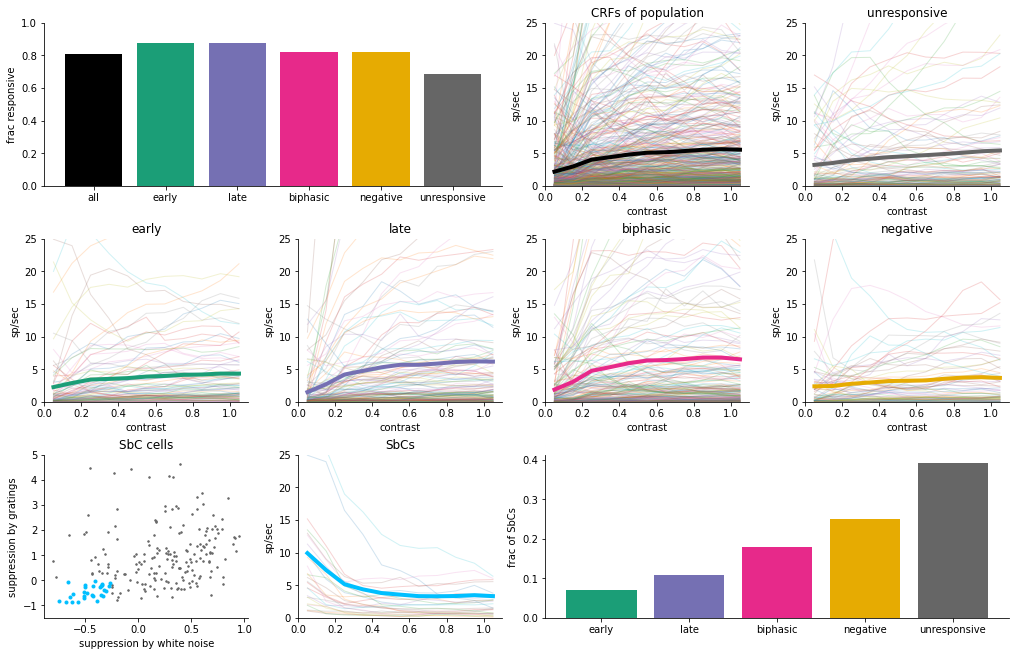

In [28]:
fig = plt.figure(constrained_layout=True, figsize=(14,9))
spec = gridspec.GridSpec(nrows=3, ncols=4, figure=fig)

ax_resp = fig.add_subplot(spec[0,0:2])
ax_crf_all = fig.add_subplot(spec[0,2])
ax_crf_unresponsive = fig.add_subplot(spec[0,3])

ax_crf_early = fig.add_subplot(spec[1,0])
ax_crf_late = fig.add_subplot(spec[1,1])
ax_crf_biphasic = fig.add_subplot(spec[1,2])
ax_crf_negative = fig.add_subplot(spec[1,3])

ax_sbc_props = fig.add_subplot(spec[2,0])
ax_sbc_crfs = fig.add_subplot(spec[2,1])
ax_sbc_fracs = fig.add_subplot(spec[2,2:])

clusters = hffm.data['movcluster'].value_counts()
contrast_clusters = hffm.data['movcluster'][hffm.data['responsive_to_contrast']].value_counts()
names = ['all','early','late','biphasic','negative','unresponsive']
ax_resp.bar(0, contrast_clusters.sum()/clusters.sum(), color=hffm.cmap_movclusts[0])
for i, name in enumerate(names[1:]):
    ax_resp.bar(i+1, contrast_clusters[name]/clusters[name], color=hffm.cmap_movclusts[1+i])
ax_resp.set_xticks(ticks=range(6), labels=names)
ax_resp.set_ylabel('frac responsive')
ax_resp.set_ylim([0,1])

crf_panels = [ax_crf_early, ax_crf_late, ax_crf_biphasic, ax_crf_negative, ax_crf_unresponsive]

all_clusters = hffm.data[hffm.data['responsive_to_contrast']]
for ind, row in all_clusters.iterrows():
    ax_crf_all.plot(row['Wn_contrast_tuning_bins'], row['Wn_contrast_tuning'], linewidth=1, alpha=0.2)
this_mean = np.nanmean(flatten_series(all_clusters['Wn_contrast_tuning']),0)
ax_crf_all.plot(row['Wn_contrast_tuning_bins'], this_mean, 'k', linewidth=4)
ax_crf_all.set_ylim([0,25])
ax_crf_all.set_title('CRFs of population')
ax_crf_all.set_ylabel('sp/sec'); ax_crf_all.set_xlabel('contrast')

for i, panel in enumerate(crf_panels):
    name = names[i+1]
    panel.set_title(name)
    this_cluster = hffm.data[hffm.data['movcluster']==name][hffm.data['responsive_to_contrast']]
    for ind, row in this_cluster.iterrows():
        panel.plot(row['Wn_contrast_tuning_bins'], row['Wn_contrast_tuning'], linewidth=1, alpha=0.2)
    panel.set_ylim([0,25])
    this_mean = np.nanmean(flatten_series(this_cluster['Wn_contrast_tuning']),0)
    panel.plot(row['Wn_contrast_tuning_bins'], this_mean, color=hffm.cmap_movclusts[i+1], linewidth=4)
    panel.set_ylabel('sp/sec'); panel.set_xlabel('contrast')

SBCs = hffm.data[hffm.data['is_SbC']]

ax_sbc_props.plot(-hffm.data['SbC_min_mid_mod'][hffm.data['responsive_to_contrast']][hffm.data['is_SbC']==False],
                  hffm.data['grat_psth_drop'][hffm.data['responsive_to_contrast']][hffm.data['is_SbC']==False],
                  '.', color=hffm.cmap_special2[0], markersize=3)
ax_sbc_props.plot(-SBCs['SbC_min_mid_mod'], SBCs['grat_psth_drop'], '.', color=hffm.cmap_special2[1], markersize=6)
ax_sbc_props.set_ylim([-1.5,5])
ax_sbc_props.set_title('SbC cells')
ax_sbc_props.set_ylabel('suppression by gratings')
ax_sbc_props.set_xlabel('suppression by white noise')

for ind, row in SBCs.iterrows():
    ax_sbc_crfs.plot(row['Wn_contrast_tuning_bins'], row['Wn_contrast_tuning'], linewidth=1, alpha=0.2)
this_mean = np.nanmean(flatten_series(SBCs['Wn_contrast_tuning']),0)
ax_sbc_crfs.plot(row['Wn_contrast_tuning_bins'], this_mean, color=hffm.cmap_special2[1], linewidth=4)
ax_sbc_crfs.set_ylim([0,25])
ax_sbc_crfs.set_title('SbCs')
ax_sbc_crfs.set_ylabel('sp/sec'); ax_crf_all.set_xlabel('contrast')

SbC_vcounts = SBCs['movcluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    ax_sbc_fracs.bar(i, SbC_vcounts[name]/SbC_vcounts.sum(), color=hffm.cmap_movclusts[1+i])
ax_sbc_fracs.set_xticks(ticks=range(5), labels=names)
ax_sbc_fracs.set_ylabel('frac of SbCs')

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/15_whitenoise.pdf')

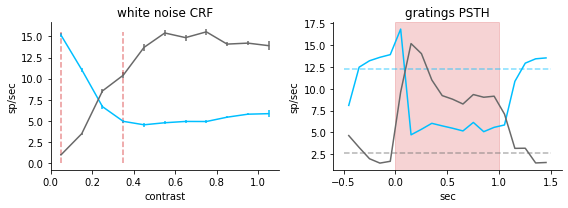

In [29]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

ex_sbc = SBCs.iloc[13]
ex_mbc = hffm.data[hffm.data['is_SbC']==False][hffm.data['responsive_to_contrast']][hffm.data['Wn_contrast_modind']>0.7].iloc[28]

ax_crf = plt.subplot(121)
ax_crf.errorbar(ex_sbc['Wn_contrast_tuning_bins'], ex_sbc['Wn_contrast_tuning'], yerr=ex_sbc['Wn_contrast_tuning_err'], color=hffm.cmap_special2[1])
ax_crf.errorbar(ex_mbc['Wn_contrast_tuning_bins'], ex_mbc['Wn_contrast_tuning'], yerr=ex_mbc['Wn_contrast_tuning_err'], color=hffm.cmap_special2[0])
ax_crf.set_ylabel('sp/sec'); ax_crf.set_xlabel('contrast')
ax_crf.vlines(0.05,0,15.5, color='tab:red', linestyle='dashed', alpha=0.5); ax_crf.vlines(0.35,0,15.5, color='tab:red', linestyle='dashed', alpha=0.5)
ax_crf.set_title('white noise CRF')

ax_psth = plt.subplot(122)
ax_psth.plot(hffm.grat_psth_x, ex_sbc['Gt_grating_psth'], color=hffm.cmap_special2[1])
ax_psth.axvspan(0,1,color='tab:red',alpha=0.2)
ax_psth.hlines(np.nanmean(ex_sbc['Gt_grating_psth'][(hffm.grat_psth_x<0)]), -0.5, 1.5, color=hffm.cmap_special2[1], linestyle='dashed', alpha=0.5)
ax_psth.hlines(np.nanmean(ex_mbc['Gt_grating_psth'][(hffm.grat_psth_x<0)]), -0.5, 1.5, color=hffm.cmap_special2[0], linestyle='dashed', alpha=0.5)
ax_psth.plot(hffm.grat_psth_x, ex_mbc['Gt_grating_psth'], color=hffm.cmap_special2[0])
ax_psth.set_ylabel('sp/sec'); ax_psth.set_xlabel('sec')
ax_psth.set_title('gratings PSTH')

fig.tight_layout()

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/15A_SbC_MbC_example.pdf')

# Figure 16: head-fixed gratings

In [9]:
def scatter_with_jitter(panel, varname, filter_for=None):
    names = ['early','late','biphasic','negative','unresponsive']
    for count, label in enumerate(names):
        s = hffm.data[varname][hffm.data['movcluster']==label]
        if filter_for is not None:
            s = s[hffm.data[filter_for]==True]
        lbound = count-0.2; ubound = count+0.2
        x_jitter = np.random.uniform(lbound, ubound, np.size(s,0))
        mean = np.nanmedian(s,0)
        stderr = np.nanstd(s) / np.sqrt(np.size(s,0))
        panel.scatter(x_jitter, s, s=3, color=hffm.cmap_movclusts[count+1])
        panel.hlines(mean, lbound, ubound, linewidth=5, color=hffm.cmap_movclusts[count+1])
        panel.vlines(count, mean-stderr, mean+stderr, linewidth=3, color=hffm.cmap_movclusts[count+1])
    panel.set_xticks(range(len(names)), labels=names)

In [10]:
def polar_ds(lpanel, rpanel, name, color):
    if name is not None:
        temp = hffm.data[hffm.data['movcluster']==name]
    else:
        temp = hffm.data
    for count, panel in enumerate([lpanel, rpanel]):
        ori = temp['Gt_best_direction'][temp['responsive_to_gratings']][temp['pref_gazeshift_direction_ind']==count].to_numpy()
        hist, _ = np.histogram(np.deg2rad(ori), bins=8, range=(0,2*np.pi))
        panel.bar(np.deg2rad(np.arange(8)*45), hist/np.max(hist), width=(2*np.pi)/8, bottom=0, color=color)
        panel.set_yticks([])#; panel.set_xticks([])

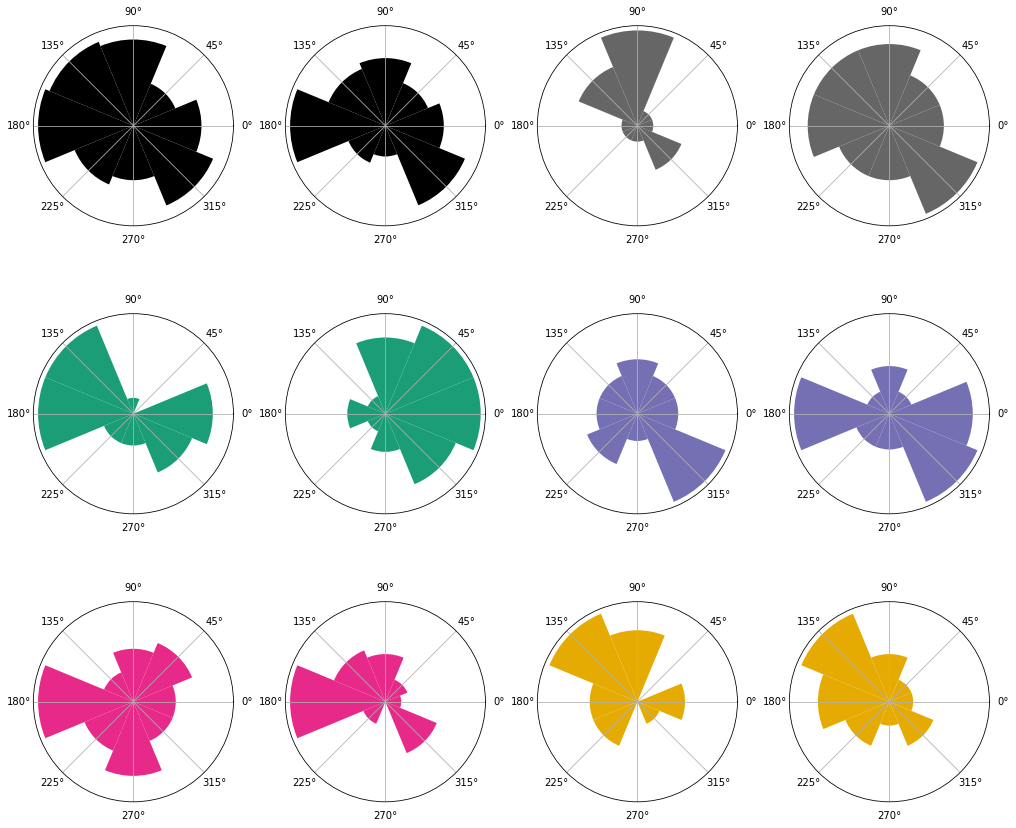

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(14,12))
spec = gridspec.GridSpec(nrows=3, ncols=4, figure=fig)

ax_all_l = fig.add_subplot(spec[0,0], projection='polar')
ax_all_r = fig.add_subplot(spec[0,1], projection='polar')
ax_unresp_l = fig.add_subplot(spec[0,2], projection='polar')
ax_unresp_r = fig.add_subplot(spec[0,3], projection='polar')
ax_early_l = fig.add_subplot(spec[1,0], projection='polar')
ax_early_r = fig.add_subplot(spec[1,1], projection='polar')
ax_late_l = fig.add_subplot(spec[1,2], projection='polar')
ax_late_r = fig.add_subplot(spec[1,3], projection='polar')
ax_biphasic_l = fig.add_subplot(spec[2,0], projection='polar')
ax_biphasic_r = fig.add_subplot(spec[2,1], projection='polar')
ax_negative_l = fig.add_subplot(spec[2,2], projection='polar')
ax_negative_r = fig.add_subplot(spec[2,3], projection='polar')

polar_ds(ax_all_l, ax_all_r, None, hffm.cmap_movclusts[0])
polar_ds(ax_unresp_l, ax_unresp_r, 'unresponsive', hffm.cmap_movclusts[5])
polar_ds(ax_early_l, ax_early_r, 'early', hffm.cmap_movclusts[1])
polar_ds(ax_late_l, ax_late_r, 'late', hffm.cmap_movclusts[2])
polar_ds(ax_biphasic_l, ax_biphasic_r, 'biphasic', hffm.cmap_movclusts[3])
polar_ds(ax_negative_l, ax_negative_r, 'negative', hffm.cmap_movclusts[4])

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/16B_polar_gratings_tuning.pdf')

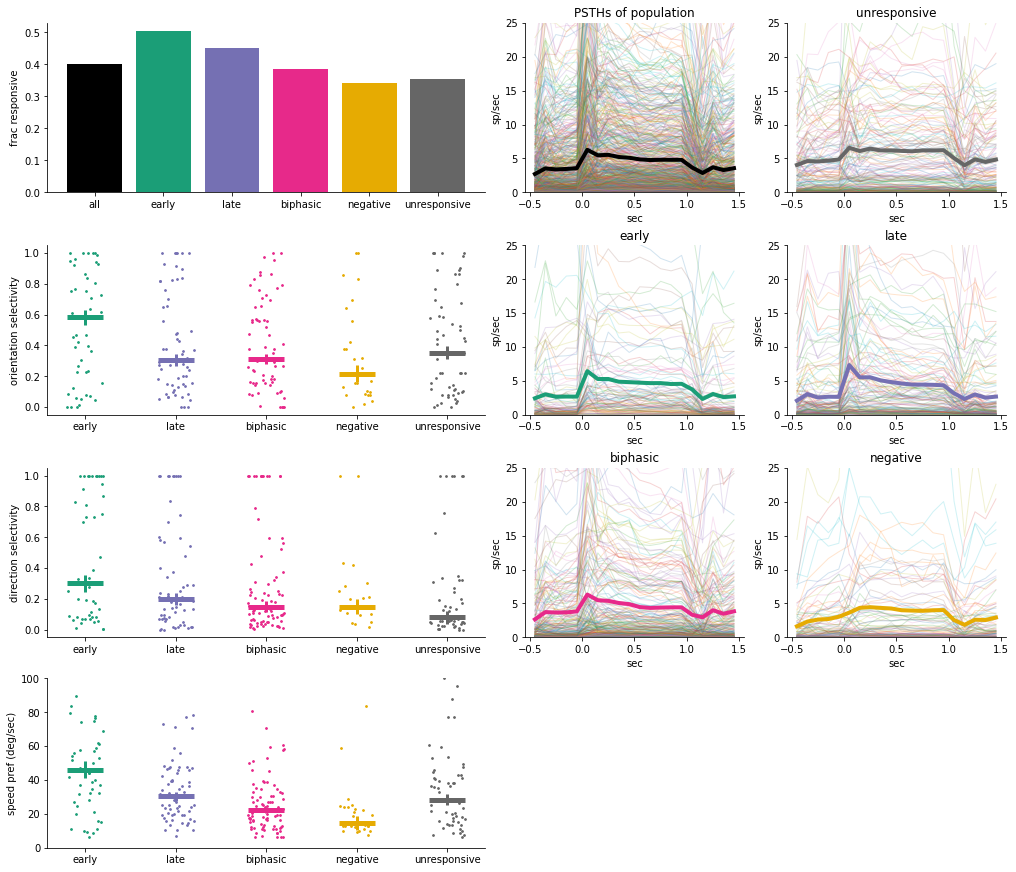

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(14,12))
spec = gridspec.GridSpec(nrows=4, ncols=4, figure=fig)

ax_resp = fig.add_subplot(spec[0,0:2])
ax_dsi = fig.add_subplot(spec[1,0:2])
ax_osi = fig.add_subplot(spec[2,0:2])
ax_speed = fig.add_subplot(spec[3,0:2])

ax_psth_all = fig.add_subplot(spec[0,2])
ax_psth_unresp = fig.add_subplot(spec[0,3])
ax_psth_early = fig.add_subplot(spec[1,2])
ax_psth_late = fig.add_subplot(spec[1,3])
ax_psth_biphasic = fig.add_subplot(spec[2,2])
ax_psth_negative = fig.add_subplot(spec[2,3])

clusters = hffm.data['movcluster'].value_counts()
contrast_clusters = hffm.data['movcluster'][hffm.data['responsive_to_gratings']].value_counts()
names = ['all','early','late','biphasic','negative','unresponsive']
ax_resp.bar(0, contrast_clusters.sum()/clusters.sum(), color=hffm.cmap_movclusts[0])
for i, name in enumerate(names[1:]):
    ax_resp.bar(i+1, contrast_clusters[name]/clusters[name], color=hffm.cmap_movclusts[1+i])
ax_resp.set_xticks(ticks=range(6), labels=names)
ax_resp.set_ylabel('frac responsive')
# ax_resp.set_ylim([0,1])

psth_panels = [ax_psth_early, ax_psth_late, ax_psth_biphasic, ax_psth_negative, ax_psth_unresp]

all_clusters = hffm.data#[hffm.data['responsive_to_gratings']]
for ind, row in all_clusters.iterrows():
    ax_psth_all.plot(hffm.grat_psth_x, row['Gt_grating_psth'], linewidth=1, alpha=0.2)
this_mean = np.nanmean(flatten_series(all_clusters['Gt_grating_psth']),0)
ax_psth_all.plot(hffm.grat_psth_x, this_mean, 'k', linewidth=4)
ax_psth_all.set_ylim([0,25])
ax_psth_all.set_title('PSTHs of population')
ax_psth_all.set_ylabel('sp/sec'); ax_psth_all.set_xlabel('sec')

for i, panel in enumerate(psth_panels):
    name = names[i+1]
    panel.set_title(name)
    this_cluster = hffm.data[hffm.data['movcluster']==name]#[hffm.data['responsive_to_gratings']]
    for ind, row in this_cluster.iterrows():
        panel.plot(hffm.grat_psth_x, row['Gt_grating_psth'], linewidth=1, alpha=0.2)
    panel.set_ylim([0,25])
    this_mean = np.nanmean(flatten_series(this_cluster['Gt_grating_psth']),0)
    panel.plot(hffm.grat_psth_x, this_mean, color=hffm.cmap_movclusts[i+1], linewidth=4)
    panel.set_ylabel('sp/sec'); panel.set_xlabel('sec')

scatter_with_jitter(ax_dsi, 'osi_for_sf_pref', filter_for='responsive_to_gratings')
ax_dsi.set_ylabel('orientation selectivity')

scatter_with_jitter(ax_osi, 'dsi_for_sf_pref', filter_for='responsive_to_gratings')
ax_osi.set_ylabel('direction selectivity')

scatter_with_jitter(ax_speed, 'grat_speed_dps', filter_for='responsive_to_gratings')
ax_speed.set_ylabel('speed pref (deg/sec)')
ax_speed.set_ylim([0,100])

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/16A_gratings.pdf')

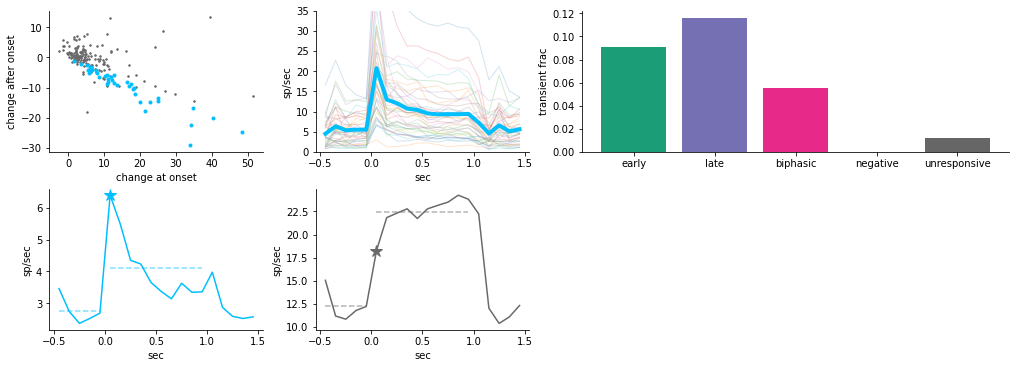

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(14,5))
spec = gridspec.GridSpec(nrows=2, ncols=4, figure=fig)

ax_props = fig.add_subplot(spec[0,0])
ax_psths = fig.add_subplot(spec[0,1])
ax_fracs = fig.add_subplot(spec[0,2:])
ax_thresh_demo1 = fig.add_subplot(spec[1,0])
ax_thresh_demo2 = fig.add_subplot(spec[1,1])

trPsth = hffm.data[hffm.data['is_grat_trpsth']][hffm.data['responsive_to_gratings']]
sPsth = hffm.data[hffm.data['responsive_to_gratings']][hffm.data['is_grat_trpsth']==False]

ax_props.plot(sPsth['change_at_gratstim_onset'], sPsth['change_during_gratstim'], '.', color=hffm.cmap_special2[0], markersize=3)
ax_props.plot(trPsth['change_at_gratstim_onset'], trPsth['change_during_gratstim'], '.', color=hffm.cmap_special2[1], markersize=6)
ax_props.set_ylabel('change after onset'); ax_props.set_xlabel('change at onset')

for ind, psth in trPsth['Gt_grating_psth'].iteritems():
    ax_psths.plot(hffm.grat_psth_x, psth, alpha=.2, linewidth=1)
this_mean = np.nanmean(flatten_series(trPsth['Gt_grating_psth']),0)
ax_psths.plot(hffm.grat_psth_x, this_mean, color=hffm.cmap_special2[1], linewidth=4)
ax_psths.set_ylim([0,35]); ax_psths.set_ylabel('sp/sec'); ax_psths.set_xlabel('sec')

SbC_vcounts = trPsth['movcluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
for n in names:
    if n not in SbC_vcounts.index.values:
        SbC_vcounts[n] = 0
for i, name in enumerate(names):
    ax_fracs.bar(i, SbC_vcounts[name]/len(hffm.data[hffm.data['movcluster']==name]), color=hffm.cmap_movclusts[1+i])
ax_fracs.set_xticks(ticks=range(len(names)), labels=names)
ax_fracs.set_ylabel('transient frac')

ex_trPsth = trPsth['Gt_grating_psth'].iloc[0]
ex_Psth = sPsth['Gt_grating_psth'].iloc[12]

win_during = (hffm.grat_psth_x<1) * (hffm.grat_psth_x>0)
win_onset = (hffm.grat_psth_x>0) * (hffm.grat_psth_x<0.10)
win_prestim = (hffm.grat_psth_x<0)

ax_thresh_demo1.plot(hffm.grat_psth_x, ex_trPsth, color=hffm.cmap_special2[1])
ax_thresh_demo1.hlines(np.mean(ex_trPsth[win_during]), hffm.grat_psth_x[win_during][0], hffm.grat_psth_x[win_during][-1], color=hffm.cmap_special2[1], linestyle='dashed', alpha=0.5)
ax_thresh_demo1.hlines(np.mean(ex_trPsth[win_prestim]), hffm.grat_psth_x[win_prestim][0], hffm.grat_psth_x[win_prestim][-1], color=hffm.cmap_special2[1], linestyle='dashed', alpha=0.5)
ax_thresh_demo1.plot(hffm.grat_psth_x[win_onset], ex_trPsth[win_onset], '*', color=hffm.cmap_special2[1], markersize=12)

ax_thresh_demo2.plot(hffm.grat_psth_x, ex_Psth, color=hffm.cmap_special2[0])
ax_thresh_demo2.hlines(np.mean(ex_Psth[win_during]), hffm.grat_psth_x[win_during][0], hffm.grat_psth_x[win_during][-1], color=hffm.cmap_special2[0], linestyle='dashed', alpha=0.5)
ax_thresh_demo2.hlines(np.mean(ex_Psth[win_prestim]), hffm.grat_psth_x[win_prestim][0], hffm.grat_psth_x[win_prestim][-1], color=hffm.cmap_special2[0], linestyle='dashed', alpha=0.5)
ax_thresh_demo2.plot(hffm.grat_psth_x[win_onset], ex_Psth[win_onset], '*', color=hffm.cmap_special2[0], markersize=12)

ax_thresh_demo1.set_ylabel('sp/sec'); ax_thresh_demo1.set_xlabel('sec')
ax_thresh_demo2.set_ylabel('sp/sec'); ax_thresh_demo2.set_xlabel('sec')

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/16C_trpsth.pdf')

# Figure 17: motor and visual direction tuning

Colormap ideas:
* depth
* cluster
* animal
* grating speed preference

In [21]:
def direcpref_scatter_c(panel, xname, yname):
    for i in range(4):
        name = ['early','late','biphasic','negative'][i]
        gaze_mi = hffm.data[xname][hffm.data['movcluster']==name]
        comp_mi = hffm.data[yname][hffm.data['movcluster']==name]
        panel.plot(gaze_mi, comp_mi, '.', color=hffm.cmap_movclusts[i+1], markersize=4)
    panel.vlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
    panel.hlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
    panel.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')
    panel.annotate('R', xy=[0.95,-0.035], color='k', alpha=0.5, fontsize=20)
    panel.annotate('L', xy=[-0.95,-0.035], color='k', alpha=0.5, fontsize=20)
    panel.annotate('R', xy=[-0.035,.95], color='k', alpha=0.5, fontsize=20)
    panel.annotate('L', xy=[-0.035,-.95], color='k', alpha=0.5, fontsize=20)

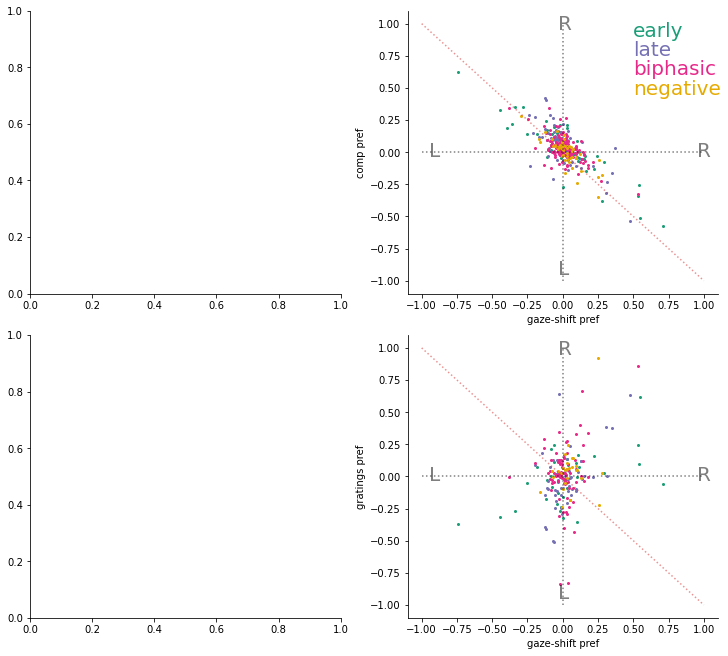

In [27]:
fig = plt.figure(constrained_layout=True, figsize=(10,9))
spec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)

ax_of_gt = fig.add_subplot(spec[0,0])
ax_gs_cp = fig.add_subplot(spec[0,1])
ax_gs_of = fig.add_subplot(spec[1,0])
ax_gs_gt = fig.add_subplot(spec[1,1])

direcpref_scatter_c(ax_gs_cp, 'gaze_sacc_LRMI', 'comp_sacc_LRMI')
ax_gs_cp.set_ylabel('comp pref')
ax_gs_cp.set_xlabel('gaze-shift pref')
ax_gs_cp.annotate('early', xy=[.5,.9], color=hffm.cmap_movclusts[1], fontsize=20)
ax_gs_cp.annotate('late', xy=[.5,.75], color=hffm.cmap_movclusts[2], fontsize=20)
ax_gs_cp.annotate('biphasic', xy=[.5,.6], color=hffm.cmap_movclusts[3], fontsize=20)
ax_gs_cp.annotate('negative', xy=[.5,.45], color=hffm.cmap_movclusts[4], fontsize=20)

direcpref_scatter_c(ax_gs_gt, 'gaze_sacc_LRMI', 'gratings_LRMI')
ax_gs_gt.set_ylabel('gratings pref')
ax_gs_gt.set_xlabel('gaze-shift pref')

fig.savefig('/home/niell_lab/Desktop/eyemov_paper/17_motor_tuning.pdf')

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(14,12))
spec = gridspec.GridSpec(nrows=5, ncols=4 figure=fig)

ax_u1_gs = fig.add_subplot(spec[0,0])
ax_u1_cp = fig.add_subplot(spec[0,1])
ax_u1_gt = fig.add_subplot(spec[0,2])
ax_u1_of = fig.add_subplot(spec[0,3])

ax_u2_gs = fig.add_subplot(spec[1,0])
ax_u2_cp = fig.add_subplot(spec[1,1])
ax_u2_gt = fig.add_subplot(spec[1,2])
ax_u2_of = fig.add_subplot(spec[1,3])

ax_u3_gs = fig.add_subplot(spec[3,0])
ax_u3_cp = fig.add_subplot(spec[3,1])
ax_u3_gt = fig.add_subplot(spec[3,2])
ax_u3_of = fig.add_subplot(spec[3,3])

ax_u4_gs = fig.add_subplot(spec[4,0])
ax_u4_cp = fig.add_subplot(spec[4,1])
ax_u4_gt = fig.add_subplot(spec[4,2])
ax_u4_of = fig.add_subplot(spec[4,3])

ax_u5_gs = fig.add_subplot(spec[5,0])
ax_u5_cp = fig.add_subplot(spec[5,1])
ax_u5_gt = fig.add_subplot(spec[5,2])
ax_u5_of = fig.add_subplot(spec[5,3])

# Light/dark data

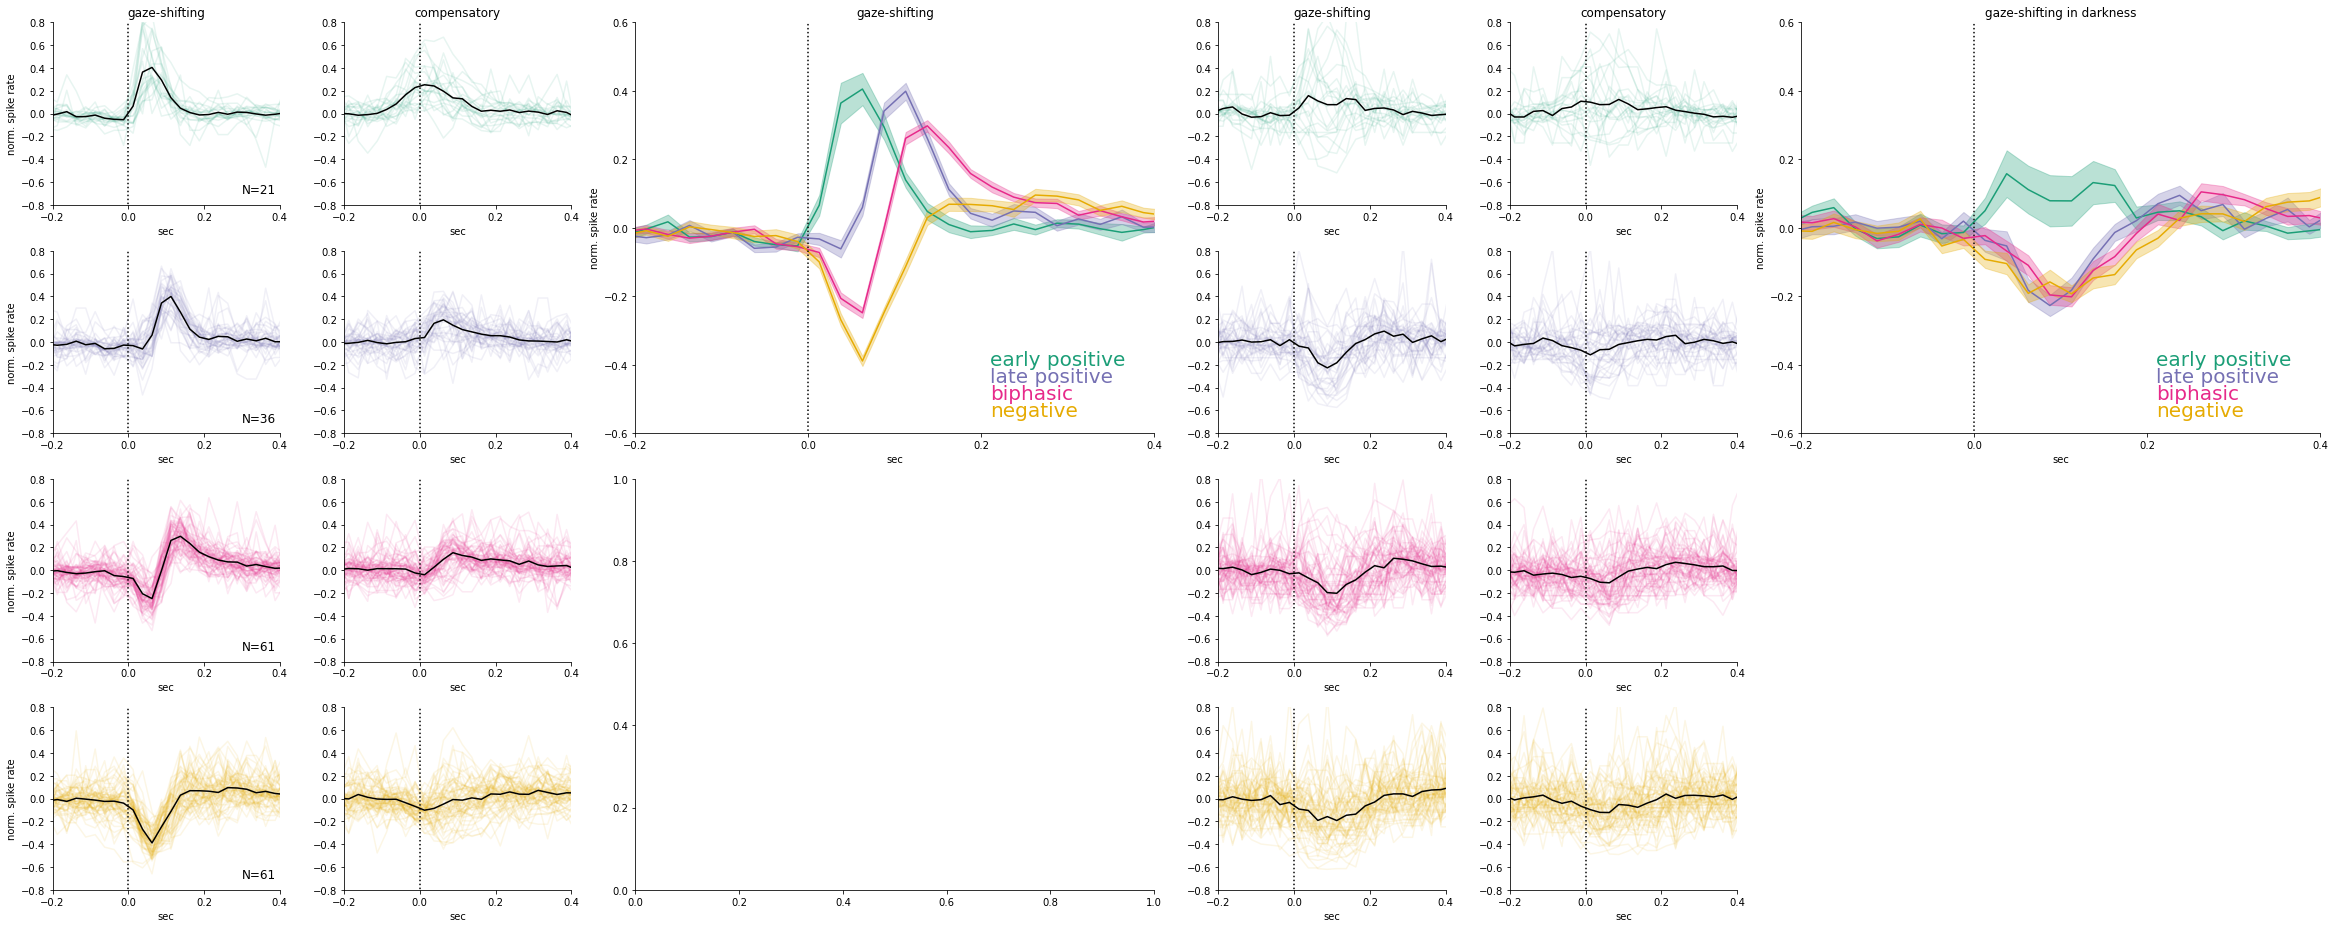

In [36]:
# fig4: light vs dark
fig4 = plt.figure(constrained_layout=True, figsize=(40,13))
spec4 = gridspec.GridSpec(ncols=10, nrows=4, figure=fig4)

# light psth
light_early_gaze = fig4.add_subplot(spec4[0,2])
light_late_gaze = fig4.add_subplot(spec4[1,2])
light_biphasic_gaze = fig4.add_subplot(spec4[2,2])
light_negative_gaze = fig4.add_subplot(spec4[3,2])

light_early_comp = fig4.add_subplot(spec4[0,3])
light_late_comp = fig4.add_subplot(spec4[1,3])
light_biphasic_comp = fig4.add_subplot(spec4[2,3])
light_negative_comp = fig4.add_subplot(spec4[3,3])

light_summary = fig4.add_subplot(spec4[0:2,4:6])
light_frac_dist = fig4.add_subplot(spec4[2:4,4:6])

# dark psth
dark_early_gaze = fig4.add_subplot(spec4[0,6])
dark_late_gaze = fig4.add_subplot(spec4[1,6])
dark_biphasic_gaze = fig4.add_subplot(spec4[2,6])
dark_negative_gaze = fig4.add_subplot(spec4[3,6])

dark_early_comp = fig4.add_subplot(spec4[0,7])
dark_late_comp = fig4.add_subplot(spec4[1,7])
dark_biphasic_comp = fig4.add_subplot(spec4[2,7])
dark_negative_comp = fig4.add_subplot(spec4[3,7])

dark_summary = fig4.add_subplot(spec4[0:2,8:10])
# dark_frac_dist = fig4.add_subplot(spec4[2:4,8:10])

psth_colors = [hffm.cmap_movclusts[1],hffm.cmap_movclusts[2], hffm.cmap_movclusts[3], hffm.cmap_movclusts[4]]
psth_keys = ['early','late','biphasic','negative']
for panelnum, panel in enumerate([light_early_gaze, light_late_gaze, light_biphasic_gaze, light_negative_gaze,
                                  light_early_comp, light_late_comp, light_biphasic_comp, light_negative_comp,
                                  dark_early_gaze, dark_late_gaze, dark_biphasic_gaze, dark_negative_gaze,
                                  dark_early_comp, dark_late_comp, dark_biphasic_comp, dark_negative_comp]):
    if panelnum==0:
        panel.set_title('gaze-shifting')
        use_movement_type = 'pref_gazeshift_psth'
    elif panelnum==4:
        panel.set_title('compensatory')
        use_movement_type = 'nonpref_comp_psth'
    if panelnum==8:
        panel.set_title('gaze-shifting')
        use_movement_type = 'pref_gazeshift_psth_FmDk'
    elif panelnum==12:
        panel.set_title('compensatory')
        use_movement_type = 'nonpref_comp_psth_FmDk'
    
    color = psth_colors[panelnum%4]
    psth_key = psth_keys[panelnum%4]
    all_psth = flatten_series(ltdk.data[use_movement_type][ltdk.data['movcluster']==psth_key])
    for i in range(len(all_psth)):
        panel.plot(ltdk.trange_x, all_psth[i], color=color, alpha=0.1)
    panel.plot(ltdk.trange_x, np.nanmean(all_psth,0), color='k')
    panel.set_xlabel('sec')
    panel.set_ylim([-0.8,0.8])
    panel.set_xlim([-0.2,0.4])
    panel.set_xticks(np.arange(-0.2,0.4,0.2))
    panel.vlines(0,-1,1,linestyles='dotted',colors='k')
    if panelnum<4 or (7>panelnum>12):
        panel.annotate('N='+str(len(all_psth)), xy=[0.3,-0.7], color='k', fontsize=12)
        panel.set_ylabel('norm. spike rate')
        
for count, label in enumerate(psth_keys):
    cluster = flatten_series(ltdk.data['pref_gazeshift_psth'][ltdk.data['movcluster']==label])
    cluster_mean = np.nanmean(cluster, 0)
    cluster_stderr = np.std(cluster,0) / np.sqrt(np.size(cluster,0))
    light_summary.plot(ltdk.trange_x, cluster_mean, color=psth_colors[count])
    light_summary.fill_between(ltdk.trange_x, cluster_mean-cluster_stderr, cluster_mean+cluster_stderr, alpha=0.3, color=psth_colors[count])
light_summary.annotate('early positive', xy=[0.21,-0.4], color=hffm.cmap_movclusts[1], fontsize=20)
light_summary.annotate('late positive', xy=[0.21,-0.45], color=hffm.cmap_movclusts[2], fontsize=20)
light_summary.annotate('biphasic', xy=[0.21,-0.5], color=hffm.cmap_movclusts[3], fontsize=20)
light_summary.annotate('negative', xy=[0.21,-0.55], color=hffm.cmap_movclusts[4], fontsize=20)
light_summary.set_xlim([-0.2,0.4])
light_summary.set_ylim([-0.6,0.6])
light_summary.vlines(0,-1,1,linestyles='dotted',colors='k')
light_summary.set_title('gaze-shifting')
light_summary.set_xticks(np.arange(-0.2,0.4,0.2))
light_summary.set_xlabel('sec')
light_summary.set_ylabel('norm. spike rate')

for count, label in enumerate(psth_keys):
    cluster = flatten_series(ltdk.data['pref_gazeshift_psth_FmDk'][ltdk.data['movcluster']==label])
    cluster_mean = np.nanmean(cluster, 0)
    cluster_stderr = np.std(cluster,0) / np.sqrt(np.size(cluster,0))
    dark_summary.plot(ltdk.trange_x, cluster_mean, color=psth_colors[count])
    dark_summary.fill_between(ltdk.trange_x, cluster_mean-cluster_stderr, cluster_mean+cluster_stderr, alpha=0.3, color=psth_colors[count])
dark_summary.annotate('early positive', xy=[0.21,-0.4], color=hffm.cmap_movclusts[1], fontsize=20)
dark_summary.annotate('late positive', xy=[0.21,-0.45], color=hffm.cmap_movclusts[2], fontsize=20)
dark_summary.annotate('biphasic', xy=[0.21,-0.5], color=hffm.cmap_movclusts[3], fontsize=20)
dark_summary.annotate('negative', xy=[0.21,-0.55], color=hffm.cmap_movclusts[4], fontsize=20)
dark_summary.set_xlim([-0.2,0.4])
dark_summary.set_ylim([-0.6,0.6])
dark_summary.vlines(0,-1,1,linestyles='dotted',colors='k')
dark_summary.set_title('gaze-shifting in darkness')
dark_summary.set_xticks(np.arange(-0.2,0.4,0.2))
dark_summary.set_xlabel('sec')
dark_summary.set_ylabel('norm. spike rate')

# immobile_rate.hist(ltdk.data['fm1_stationary_rec_rate'] - ltdk.data['fm_dark_stationary_rec_rate'], density=True, bins=np.arange(-30, 33, 3), color='tab:gray')
# immobile_rate.set_xlabel('light - dark firing rate')
# immobile_rate.set_title('immobile')
# immobile_rate.set_ylim([0,0.18])

# active_rate.hist(ltdk.data['fm1_active_rec_rate'] - ltdk.data['fm_dark_active_rec_rate'], density=True, bins=np.arange(-30, 33, 3), color='tab:gray')
# active_rate.set_xlabel('light - dark firing rate')
# active_rate.set_title('active')
# active_rate.set_ylim([0,0.18])

fig4.tight_layout()
# fig4.savefig('/home/niell_lab/Desktop/lightdark.pdf')

In [36]:
[col for col in ltdk.data.columns if 'pref_gazeshift_psth' in col]

['pref_gazeshift_psth_FmDk',
 'nonpref_gazeshift_psth_FmDk',
 'pref_gazeshift_psth',
 'nonpref_gazeshift_psth']

In [43]:
hffm.data[hffm.data['dsi_for_sf_pref']>0.9]

,level_0,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,FmLt_n_spikes,...,grat_psth_drop,change_at_gratstim_onset,change_during_gratstim,is_SbC,is_grat_trpsth,gaze_sacc_LRMI,comp_sacc_LRMI,gaze_sacc_pnpMI,comp_sacc_pnpMI,gratings_LRMI
1,14,3731.4,0.0,good,96.931038,5,650,0.873588,good,4810,...,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN
4,20,6447.6,3.6,good,82.735550,5,650,0.904645,good,4981,...,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN
10,61,3525.6,1.1,good,103.290169,12,475,1.132032,good,6233,...,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN
12,67,1647.1,0.0,good,111.256569,13,450,0.220486,good,1214,...,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN
14,76,3200.5,3.0,good,91.697075,14,425,2.234461,good,12303,...,0.377622,0.552258,-0.273548,False,False,0.009155,0.104904,0.009155,0.104904,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,434,1800.0,0.0,good,139.469208,122,125,0.712771,good,3764,...,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN
706,435,1676.0,0.0,good,139.759232,122,125,0.333093,good,1759,...,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN
711,449,1438.8,7.5,good,78.571480,124,75,0.460158,good,2430,...,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN
712,452,2357.1,0.0,good,115.949341,125,50,0.265111,good,1400,...,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN


# Optic flow

In [24]:
opfl_units = hffm.data[hffm.data['has_optic_flow']][hffm.data['dsi_for_sf_pref']>.9]
print(opfl_units.index.values)

[ 80  84  86  93 109 113 117 125 129 130 131 133 138 146 150 162 166 168
 176 177 185 188 199 217 220 222 227 229 230 236 251 252 253 256 405 407
 408 411 416 422 424 436 439 441 442 447 448 449 450 452 471 476 481 484
 485 489 490 491 502 503 506 514 518 519 522 525 527 528]


In [25]:
opfl_exinds = [80, 84, 86, 93, 109]

In [26]:
def plot_gratings_tuning(panel, ind, tf=0):
    raw_tuning = hffm.data[ind, 'Gt_ori_tuning_tf'][:,:,tf]
    drift_spont = hffm.data[ind, 'Gt_drift_spont']
    panel.plot(np.arange(8)*45, raw_tuning[:,0], label='low sf', color=self.cmap_orientation[0])
    panel.plot(np.arange(8)*45, raw_tuning[:,1], label='mid sf', color=self.cmap_orientation[1])
    panel.plot(np.arange(8)*45, raw_tuning[:,2], label='high sf', color=self.cmap_orientation[2])
    panel.plot([0,315], [drift_spont,drift_spont], ':', label='spont', color=self.cmap_orientation[3])

In [27]:
[col for col in opfl_units.columns.values if 'optic_flow' in col]

['use_in_optic_flow',
 'has_optic_flow',
 'has_topdown_optic_flow',
 'FmLt_optic_flow_full_amp',
 'FmLt_optic_flow_full_vec',
 'FmLt_optic_flow_active_gyro_amp',
 'FmLt_optic_flow_active_gyro_vec',
 'FmLt_optic_flow_inactive_gyro_amp',
 'FmLt_optic_flow_inactive_gyro_vec',
 'FmLt_optic_flow_running_forward_amp',
 'FmLt_optic_flow_running_forward_vec',
 'FmLt_optic_flow_running_backward_amp',
 'FmLt_optic_flow_running_backward_vec',
 'FmLt_optic_flow_fine_motion_amp',
 'FmLt_optic_flow_fine_motion_vec',
 'FmLt_optic_flow_immobile_amp',
 'FmLt_optic_flow_immobile_vec']

In [ ]:
def plot_optic_flow(panel, ind, statename='full', nx=5):
    # amplitude
    amp = opfl_units[ind, 'FmLt_optic_flow_'+statename+'_amp'].astype(float)
    panel.imshow(fa, cmap='Reds')
    
    # flow vectors
    fv_scale = opfl_units[ind, 'FmLt_flowvec_scale']
    flow_w = np.size(fv, 1)
    flow_h = np.size(fv, 0)
    X,Y = np.meshgrid(np.arange(0,flow_w),np.arange(0,flow_h))
    U = fv[:,:,0]; V = fv[:,:,1]
    panel.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)
    
    panel.axis('off')
    panel.axis('equal')

(<Figure size 1440x360 with 10 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

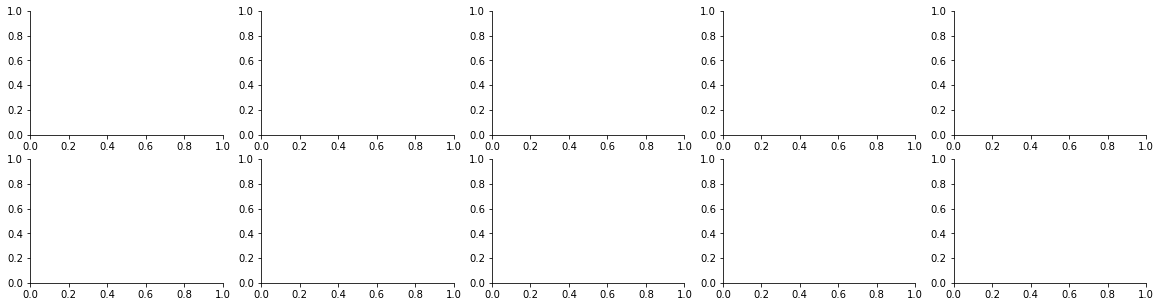

In [41]:
fig = plt.subplots(5,3,figisze=(10,7))

for i, ind in enumerate(opfl_exinds):
    
    

for i, ind in enumerate(opfl_exinds):
    panel = opfl_panels[i]
    
    plot_gratings_tuning(paen)

# read in the old dataset

In [37]:
old_hffm = pd.read_pickle('/home/niell_lab/data/freely_moving_ephys/batch_files/120221_hffm/pooled_ephys_population_update_120621.pickle')
old_ltdk = pd.read_pickle('/home/niell_lab/data/freely_moving_ephys/batch_files/120221_lightdark/pooled_ephys_population_update_120621.pickle')


In [38]:
old_ltdk['session'].unique()

array(['100921_J559RT_control_Rig2', '101621_J559NC_control_Rig2',
       '102721_J558NC_control_Rig2', '110421_J558LT_control_Rig2',
       '110521_J569LT_control_Rig2'], dtype=object)

In [39]:
ltdk.data['session'].unique()

array(['100821_J559TT_control_Rig2', '101621_J559NC_control_Rig2',
       '102721_J558NC_control_Rig2', '110421_J558LT_control_Rig2',
       '110521_J569LT_control_Rig2'], dtype=object)

In [50]:
sdatas = [old_hffm, old_ltdk, hffm.data, ltdk.data]

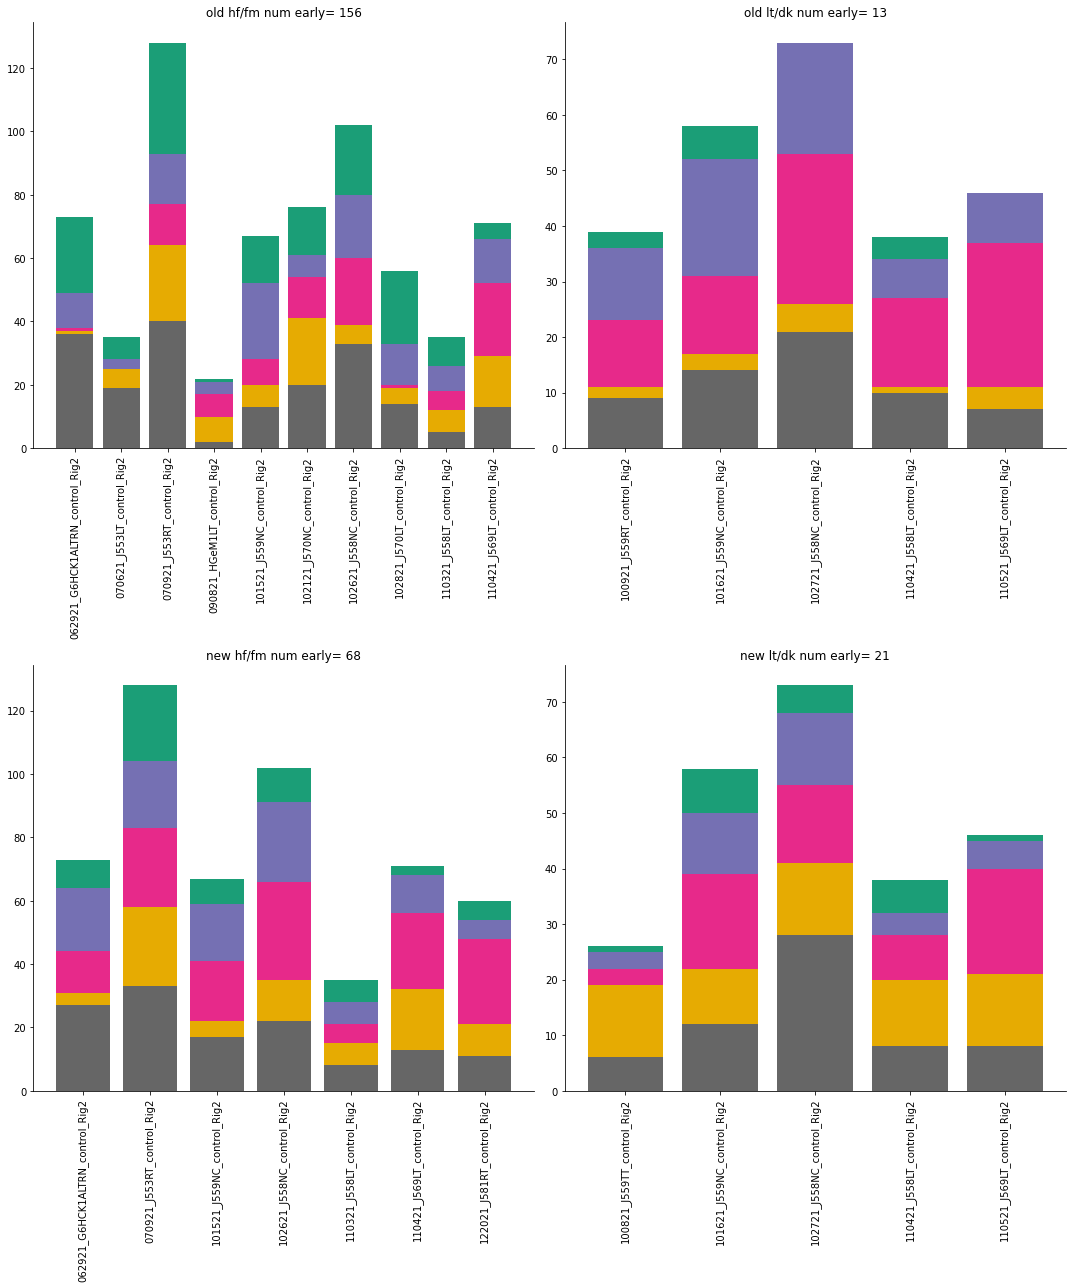

In [79]:
plt.subplots(2,2,figsize=(15,18))
for panel in range(4):
    plt.subplot(2,2,panel+1)
    titletext = ['old hf/fm','old lt/dk','new hf/fm','new lt/dk'][panel]
    sdata = sdatas[panel]
    key = ('movement_psth_type_simple' if 'old' in titletext else 'movcluster')
    slist = sdata['session'].unique()
    plt.title(titletext + ' num early= ' + str(sdata[key].value_counts()['early']))
    for i, session in enumerate(slist):
        vc = sdata[key][sdata['session']==session].value_counts()
#         movtype = ['unresponsive','negative','biphasic','late','early']
        if 'unresponsive' in vc.index.values:
            plt.bar(i, height=vc['unresponsive'], color=hffm.cmap_movclusts[5])
        else:
            vc['unresponsive'] = 0
        if 'negative' in vc.index.values:
            plt.bar(i, height=vc['negative'], bottom=vc['unresponsive'], color=hffm.cmap_movclusts[4])
        else:
            vc['negative'] = 0
        if 'biphasic' in vc.index.values:
            plt.bar(i, height=vc['biphasic'], bottom=vc['unresponsive']+vc['negative'],
                    color=hffm.cmap_movclusts[3])
        else:
            vc['biphasic'] = 0
        if 'late' in vc.index.values:
            plt.bar(i, height=vc['late'], bottom=vc['unresponsive']+vc['negative']+vc['biphasic'],
                    color=hffm.cmap_movclusts[2])
        else:
            vc['late'] = 0
        if 'early' in vc.index.values:
            plt.bar(i, height=vc['early'], bottom=vc['unresponsive']+vc['negative']+vc['biphasic']+vc['late'],
                    color=hffm.cmap_movclusts[1])
        else:
            vc['early'] = 0
        
#         b = 0; h = 0
#         for x, m in enumerate(movtype):
#             xcolor = [5,4,3,2,1][x]
#             if m in vc.index.values:
#                 h += int(vc[m])
#                 print(x, m, b, h)
#                 plt.bar(i, bottom=vc[, height=h, color=hffm.cmap_movclusts[xcolor])
#                 b += int(vc[m])
    plt.xticks(range(len(slist)), labels=slist, rotation=90)
plt.tight_layout()

In [61]:
ltdk.data['movcluster'].value_counts()

unresponsive    62
negative        61
biphasic        61
late            36
early           21
Name: movcluster, dtype: int64

In [62]:
ltdk.data[ltdk.data['session']=='102721_J558NC_control_Rig2'][ltdk.data['movcluster']=='early']

,level_0,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,FmLt_n_spikes,...,pref_gazeshift_psth,pref_comp_psth,nonpref_gazeshift_psth,nonpref_comp_psth,mov_kmclust,movcluster,biphasic_comp_responsive,early_comp_responsive,late_comp_responsive,negative_comp_responsive
91,67,1415.6,2.1,good,81.910431,28,75,23.282529,good,56715,...,"[-0.031386415226121504, -0.009647284791338607,...","[0.08723744535665316, 0.0925471798699276, 0.05...","[0.014037802586493103, 0.05440477506355767, 0....","[-0.007589717157404882, 0.017009213323877254, ...",1,early,NaN,True,NaN,NaN
116,203,2823.7,0.0,good,122.145325,86,225,12.458811,good,30349,...,"[-0.0015852885225105132, -0.01145370957514239,...","[-0.009341067975605428, 0.03757251227130832, -...","[-0.04126093414754797, 0.030656874071629873, 0...","[-0.08519793459552524, -0.16038590452033738, -...",1,early,NaN,True,NaN,NaN
124,223,1288.8,9.2,good,79.063896,89,150,11.691964,good,28481,...,"[-0.02588615330888714, 0.04295442640125774, 0....","[-0.09440989765513638, -0.0030120481927705693,...","[-0.018362840429240364, 0.07810018207879915, 0...","[-0.0977335917094956, 0.007161513185609498, -0...",1,early,NaN,True,NaN,NaN
142,291,764.1,4.3,good,74.026169,116,275,12.246984,good,29833,...,"[0.004599942119934026, 0.02609172467366372, -0...","[-0.09434753941137815, -0.10429778816759712, -...","[-0.07373798993442096, 0.00010167251283630444,...","[-0.051805717222715854, -0.06309806352133548, ...",1,early,NaN,True,NaN,NaN
150,316,708.4,9.3,good,74.789986,123,100,12.922286,good,31478,...,"[-0.08422037665223979, -0.11528833781728937, -...","[-0.09383452176051202, -0.09000799114826723, -...","[-0.034187222074416775, -0.008950629014479978,...","[-0.10181429234525843, -0.08338883170874227, -...",1,early,NaN,False,NaN,NaN
